In [1]:
import os
import random
from pathlib import Path
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

CONFIG & REPRODUCIBILITY

In [2]:

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Mixed precision (optional, helps on newer GPUs)
# Uncomment if you have a supported GPU
# from tensorflow.keras import mixed_precision
# mixed_precision.set_global_policy("mixed_float16")

PATHS & BASIC SETTINGS

In [3]:

from pathlib import Path

# Apne dataset ka root folder path yaha do (raw string ya forward slashes use karo)
DATASET_ROOT = Path(r"C:/Users/babul/OneDrive/Desktop/project/afghan_hound")
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Existence check (agar path galat hai to error raise hoga)
assert DATASET_ROOT.exists(), f"Dataset path not found: {DATASET_ROOT}"
print("Dataset root:", DATASET_ROOT.resolve())


Dataset root: C:\Users\babul\OneDrive\Desktop\project\afghan_hound


DATA LOADING STRATEGY

In [4]:

# The code supports two layouts:
# A) dataset_root/<class>/*.jpg   (no split folders) -> uses validation_split
# B) dataset_root/train/<class>/*.jpg and dataset_root/val/<class>/*.jpg

train_dir = DATASET_ROOT / "train"
val_dir   = DATASET_ROOT / "val"
test_dir  = DATASET_ROOT / "test"  # optional

USE_EXPLICIT_SPLIT = train_dir.exists() and val_dir.exists()
print("Using explicit split:", USE_EXPLICIT_SPLIT)

AUTOTUNE = tf.data.AUTOTUNE

def make_datasets():
    if USE_EXPLICIT_SPLIT:
        train_ds = keras.utils.image_dataset_from_directory(
            train_dir,
            labels="inferred",
            label_mode="int",
            image_size=IMG_SIZE,
            batch_size=BATCH_SIZE,
            shuffle=True,
            seed=SEED,
        )
        val_ds = keras.utils.image_dataset_from_directory(
            val_dir,
            labels="inferred",
            label_mode="int",
            image_size=IMG_SIZE,
            batch_size=BATCH_SIZE,
            shuffle=False,
        )
        class_names = train_ds.class_names
        # Optional test set
        test_ds = None
        if test_dir.exists():
            test_ds = keras.utils.image_dataset_from_directory(
                test_dir,
                labels="inferred",
                label_mode="int",
                image_size=IMG_SIZE,
                batch_size=BATCH_SIZE,
                shuffle=False,
            )
        return train_ds, val_ds, test_ds, class_names

    # No explicit split—use validation_split from the full root
    train_ds = keras.utils.image_dataset_from_directory(
        DATASET_ROOT,
        validation_split=0.2,
        subset="training",
        seed=SEED,
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        label_mode="int",
        shuffle=True,
    )
    val_ds = keras.utils.image_dataset_from_directory(
        DATASET_ROOT,
        validation_split=0.2,
        subset="validation",
        seed=SEED,
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        label_mode="int",
        shuffle=False,
    )
    class_names = train_ds.class_names
    return train_ds, val_ds, None, class_names

train_ds, val_ds, test_ds, class_names = make_datasets()
NUM_CLASSES = len(class_names)
print("Classes:", class_names)

# tf.data performance tweaks
def tune(ds, training=False):
    if training:
        ds = ds.shuffle(8 * BATCH_SIZE, seed=SEED, reshuffle_each_iteration=True)
    return ds.prefetch(AUTOTUNE)

train_ds = tune(train_ds, training=True)
val_ds = tune(val_ds, training=False)
if test_ds is not None:
    test_ds = tune(test_ds, training=False)


Using explicit split: False
Found 125 files belonging to 1 classes.
Using 100 files for training.
Found 125 files belonging to 1 classes.
Using 25 files for validation.
Classes: ['afghan_hound']


DATA AUGMENTATION

In [5]:

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.05),
        layers.RandomZoom(0.1),
        layers.RandomContrast(0.1),
    ],
    name="augmentation",
)

MODEL (Transfer Learning)

In [6]:

# Choose a backbone: "MobileNetV2" is fast; EfficientNetB0/B1 is also great
BACKBONE = keras.applications.MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights="imagenet"
)

BACKBONE.trainable = False  # freeze base for warmup

inputs = keras.Input(shape=IMG_SIZE + (3,))
x = layers.Rescaling(1./255)(inputs)
x = data_augmentation(x)
x = BACKBONE(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs, outputs, name="dog_breed_classifier")

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "dog_breed_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augmentation (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

CALLBACKS

In [7]:

ckpt_dir = Path("./checkpoints")
ckpt_dir.mkdir(parents=True, exist_ok=True)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath=str(ckpt_dir / "best.keras"),
        monitor="val_accuracy",
        mode="max",
        save_best_only=True,
        verbose=1,
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        mode="max",
        patience=5,
        restore_best_weights=True,
        verbose=1,
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=2,
        min_lr=1e-6,
        verbose=1,
    ),
]


TRAIN (Warmup with frozen base)

In [8]:

EPOCHS_WARMUP = 5
history1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_WARMUP,
    callbacks=callbacks,
)


Epoch 1/5


c:\Users\babul\anaconda3\Lib\site-packages\keras\src\ops\nn.py:938: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 1: val_accuracy improved from None to 0.00000, saving model to checkpoints\best.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 25s 4s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 2: val_accuracy did not improve from 0.00000
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 768ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 624ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 770ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 

FINE-TUNE (Unfreeze top of the backbone)

In [9]:

BACKBONE.trainable = True
# Unfreeze top N layers (fine-tune last 40 layers for example)
for layer in BACKBONE.layers[:-40]:
    layer.trainable = False

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=5e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

EPOCHS_FINETUNE = 15
history2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_FINETUNE,
    callbacks=callbacks,
)


Epoch 1/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 537ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 1: val_accuracy did not improve from 0.00000
4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 5.0000e-05
Epoch 2/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 547ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 2: val_accuracy did not improve from 0.00000

Epoch 2: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 693ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 5.0000e-05
Epoch 3/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 602ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3: val_accuracy did not improve from 0.00000
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 751ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 2.5000e-05
Epoch 4/15
4/4 ━━━━

PLOTS: Training Curves

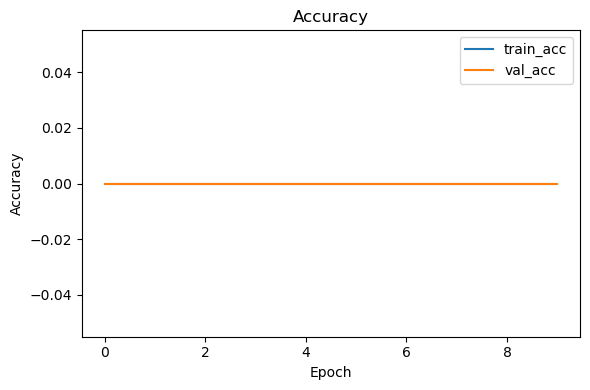

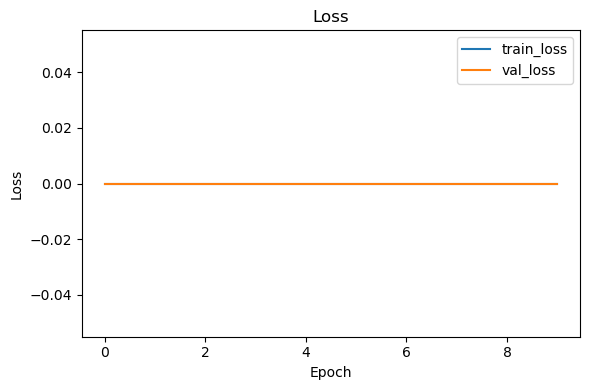

In [10]:

def plot_history(histories):
    acc = []
    val_acc = []
    loss = []
    val_loss = []
    for h in histories:
        acc += h.history.get("accuracy", [])
        val_acc += h.history.get("val_accuracy", [])
        loss += h.history.get("loss", [])
        val_loss += h.history.get("val_loss", [])

    plt.figure(figsize=(6,4))
    plt.plot(acc, label="train_acc")
    plt.plot(val_acc, label="val_acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Accuracy")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6,4))
    plt.plot(loss, label="train_loss")
    plt.plot(val_loss, label="val_loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss")
    plt.tight_layout()
    plt.show()

plot_history([history1, history2])


EVALUATION (Val / Test)

c:\Users\babul\anaconda3\Lib\site-packages\keras\src\ops\nn.py:938: UserWarning: You are using a softmax over axis -1 of a tensor of shape (25, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

Validation Classification Report:
              precision    recall  f1-score   support

afghan_hound     1.0000    1.0000    1.0000        25

    accuracy                         1.0000        25
   macro avg     1.0000    1.0000    1.0000        25
weighted avg     1.0000    1.0000    1.0000        25



c:\Users\babul\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


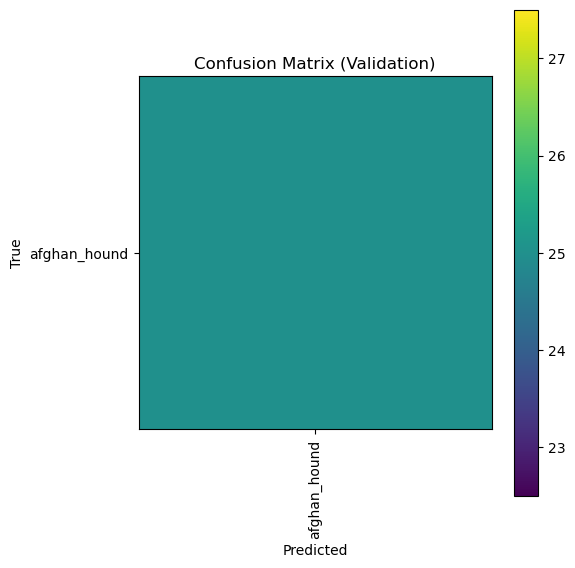

In [11]:

def ds_to_numpy(ds):
    xs, ys = [], []
    for batch_x, batch_y in ds:
        xs.append(batch_x.numpy())
        ys.append(batch_y.numpy())
    X = np.concatenate(xs, axis=0)
    y = np.concatenate(ys, axis=0)
    return X, y

val_X, val_y = ds_to_numpy(val_ds)
val_pred_probs = model.predict(val_X, batch_size=BATCH_SIZE)
val_pred = np.argmax(val_pred_probs, axis=1)

print("\nValidation Classification Report:")
print(classification_report(val_y, val_pred, target_names=class_names, digits=4))

cm = confusion_matrix(val_y, val_pred)
plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix (Validation)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)
plt.tight_layout()
plt.show()

if test_ds is not None:
    test_X, test_y = ds_to_numpy(test_ds)
    test_pred_probs = model.predict(test_X, batch_size=BATCH_SIZE)
    test_pred = np.argmax(test_pred_probs, axis=1)
    print("\nTest Classification Report:")
    print(classification_report(test_y, test_pred, target_names=class_names, digits=4))


SAVE MODEL

In [12]:

save_dir = Path("./export")
save_dir.mkdir(parents=True, exist_ok=True)
model.save(save_dir / "dog_breed_classifier.keras")
# Optional H5:
model.save(save_dir / "dog_breed_classifier.h5")


INFERENCE HELPER

In [13]:

def predict_image(img_path: Path, top_k: int = 3):
    img = keras.utils.load_img(img_path, target_size=IMG_SIZE)
    arr = keras.utils.img_to_array(img)
    arr = np.expand_dims(arr, 0) / 255.0
    probs = model.predict(arr)[0]
    top_idx = probs.argsort()[-top_k:][::-1]
    return [(class_names[i], float(probs[i])) for i in top_idx]

# Example:
# test_image = Path(r"C:/Users/babul/OneDrive/Desktop/project/some_dog.jpg")
# print(predict_image(test_image, top_k=5))

SAMPLE VISUAL PREDS

c:\Users\babul\anaconda3\Lib\site-packages\keras\src\ops\nn.py:938: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


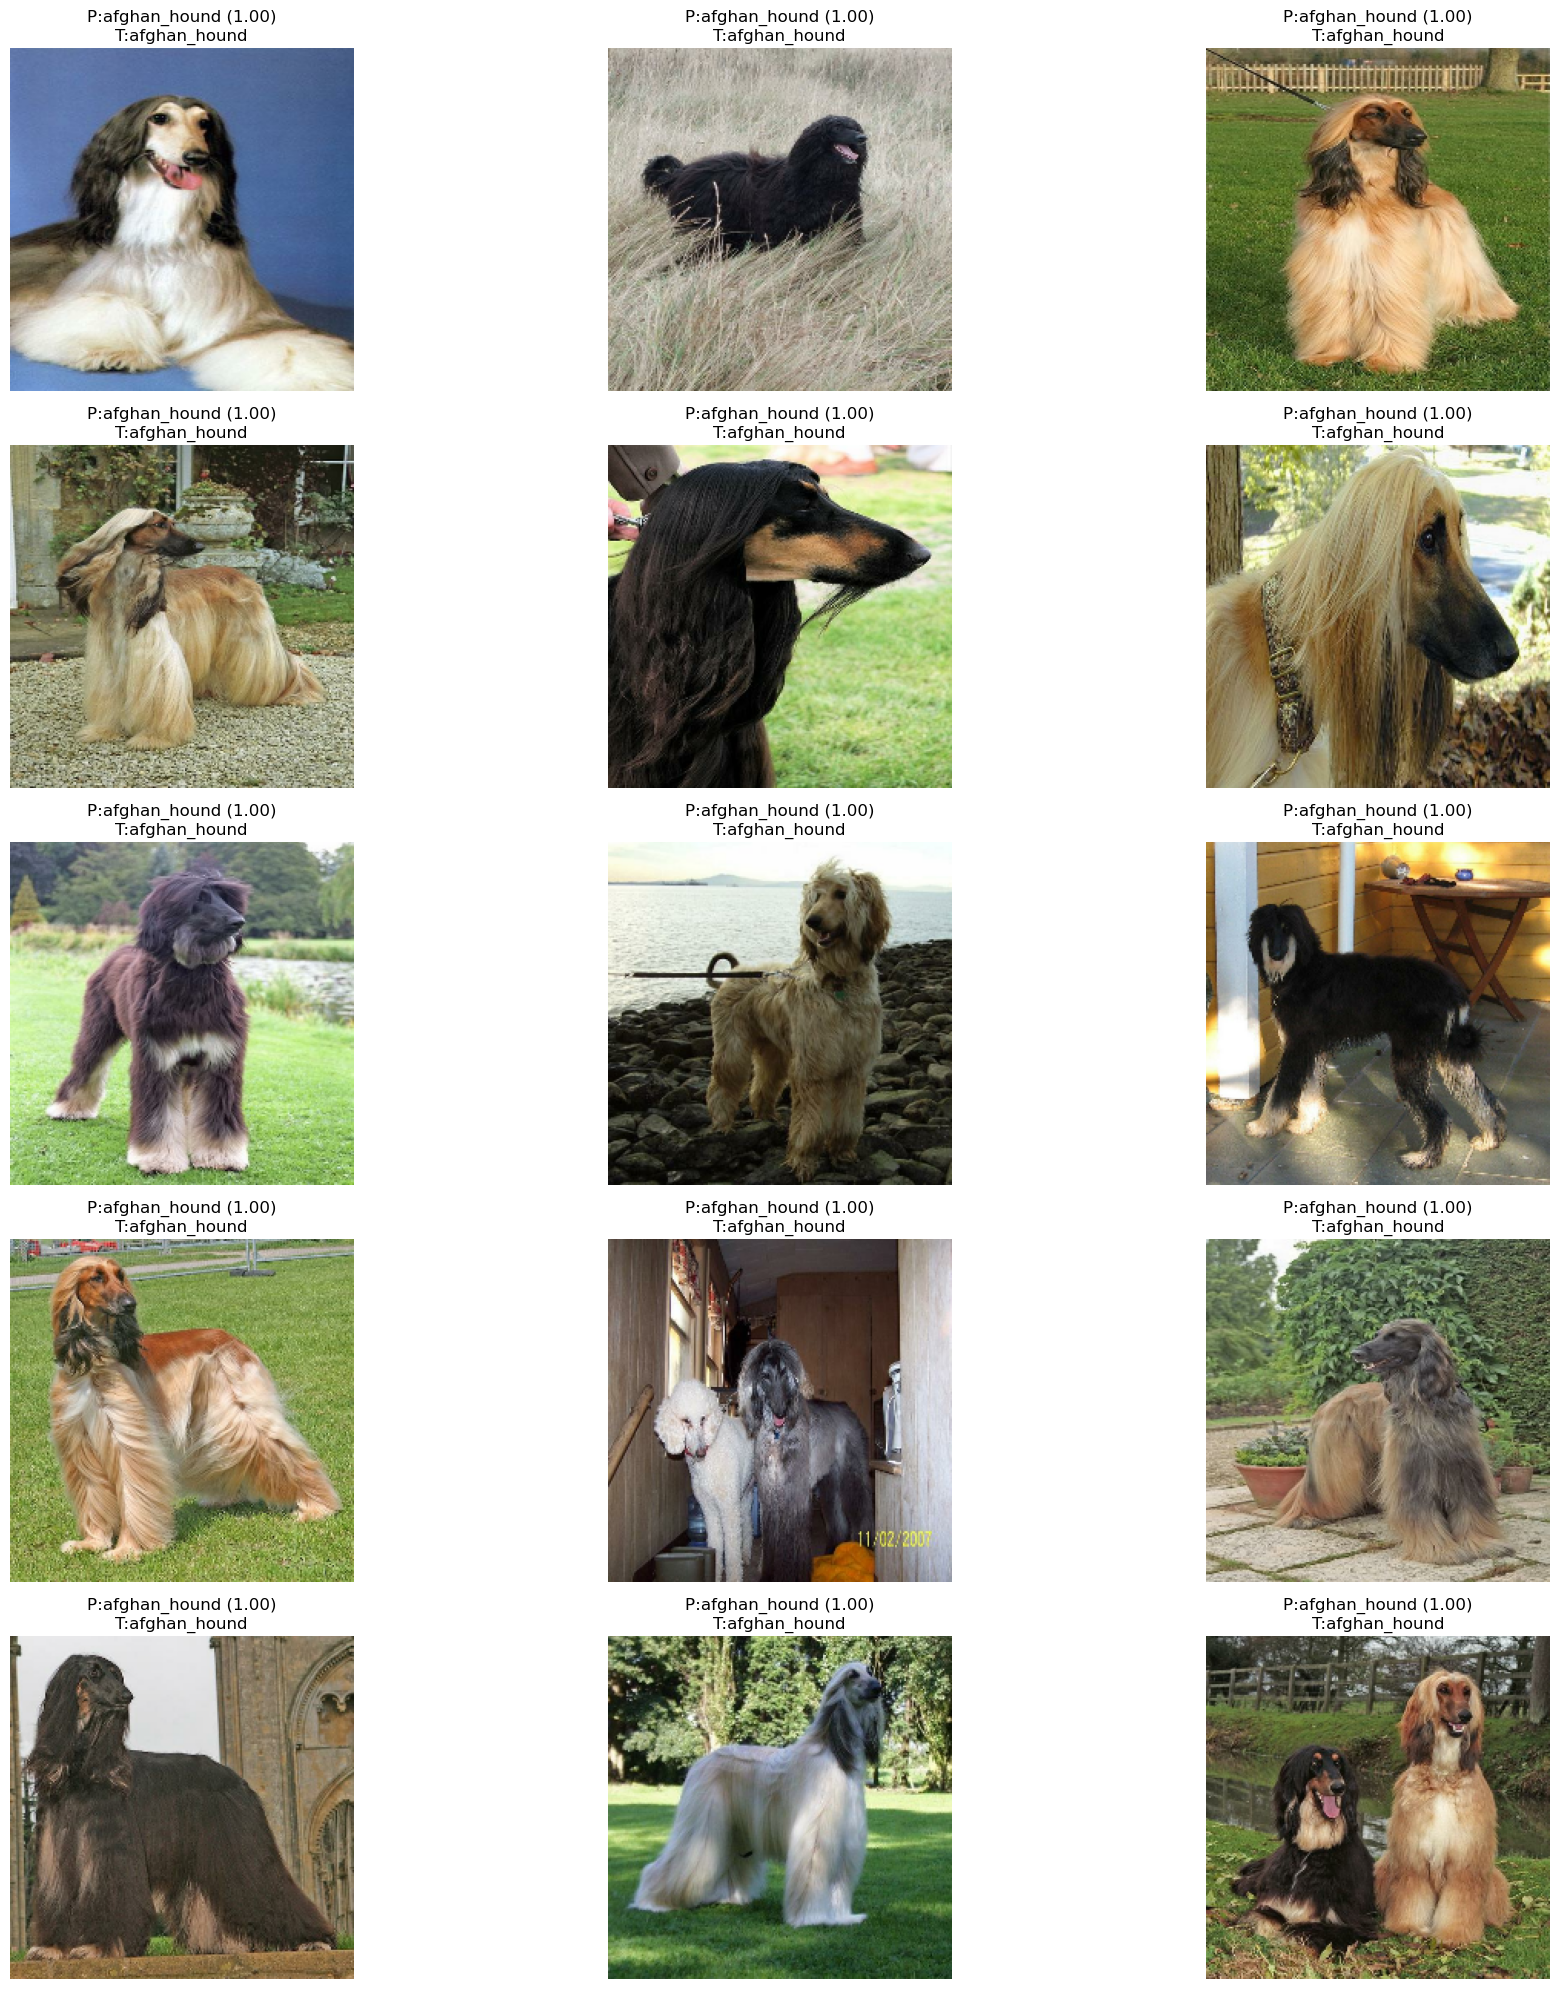


✅ Training complete. Model exported to: C:\Users\babul\OneDrive\Desktop\project\export


In [14]:

def show_sample_predictions(ds, n=15):
    imgs, labels = next(iter(ds.unbatch().batch(n)))
    probs = model.predict(imgs, verbose=0)
    preds = probs.argmax(axis=1)

    plt.figure(figsize=(20,20))
    for i in range(n):
        plt.subplot(5,3,i+1)
        plt.imshow(imgs[i].numpy().astype("uint8"))
        true_label = class_names[int(labels[i])]
        pred_label = class_names[int(preds[i])]
        conf = probs[i, preds[i]]
        title = f"P:{pred_label} ({conf:.2f})\nT:{true_label}"
        plt.title(title)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_sample_predictions(val_ds, n=15)

print("\n✅ Training complete. Model exported to:", save_dir.resolve())